## Issue with very high loglikelihood in generated data

## Goal
I was trying to generate new data from fitted model of `GTEx`. However, I realize that the average oracle poisson loglikelihood is much higher than the average poisson loglikelihood from the fit with GTEx dataset (`-2` vs `-115`), which is surprising. Most probably there is a bug. I am trying to find it out. 

I use the function below to compute loglikelihood (I recomputed the some of the loglikelihood below) 

```{r}
## compute both multinomial and poisson logliklihood for both multinomial and poisson model
## X is [n_feature, n_sample] matrix;
## A is [n_feature,K] factor (A = F)
## W is [K,n_sample] loading (transpose) (W = t(L))
compute_ll <- function(X,A,W, e = .Machine$double.eps){
  p = nrow(X)
  n = ncol(X)
  if(mean(colSums(A %*% W)) < 1.1){ ## this is multinomial model
    theta = A %*% W ## parameter for multinom distribution
    multinom_ll = sum(X * log(theta + e))
    lam = theta %*% diag(colSums(X))
    pois_ll = sum(dpois(X,lam, log= TRUE))/(n*p)
    return(list(type = "multinom", multinom_ll = multinom_ll, pois_ll = pois_ll))
  }
  else{ ## this is poisson model
    pois_ll = sum(dpois(X,A %*% W, log= TRUE))/(n*p)
    out = poisson2multinom(A,t(W))
    Ahat = out$F
    What = t(out$L)
    theta = Ahat %*% What
    multinom_ll = sum(X * log(theta + e))
    return(list(type = "poisson", multinom_ll = multinom_ll, pois_ll = pois_ll))
    }
}
```

### The loglikelihood computed are listed here 
```
* In fitting the GTEx, we have the following loglikelihood (model | GTEx)
 
method  time(s) multinom ll             pois ll (mean)

nnmf    15406   -5527555982054.788      -115.5841

* But in generating and fitting the oracle, we have the following (model | simulated data from oracle, which is nnmf)

method  time(s) multinom ll             pois ll (mean)

oracle          -5535274871489.7959     -2.108910154212

maptpx  46273   -5535547915113.8789     -2.527085324929

nnmf    15581   -5535274339301.6719     -2.108086114508
```



In [2]:
data.dir           <- file.path("../../topics-simulation-bigdata","output")
read.counts.file   <- "gtex.csv.gz"
## they are fitted by `topics/script/fit_gtex_nnlm.R`
read.factors.file   <- "gtex_factors_nnmf.csv.gz"
read.loadings.file   <- "gtex_loadings_nnmf.csv.gz"

# SET UP ENVIRONMENT
# ------------------
# Load packages and function definitions.
library(readr)
library(NNLM)
source(file.path("..","code","misc.R"))
source(file.path("..","code","utility.R"))


In [3]:
# LOAD DATA
# --------------
cat("Loading GTEx data.\n")
read.counts.file <- file.path(data.dir,read.counts.file)
counts <- read.csv.matrix(read.counts.file)
cat(sprintf("Loaded %d x %d count matrix.\n",nrow(counts),ncol(counts)))

Loading GTEx data.
Loaded 11688 x 55863 count matrix.


In [4]:
# LOAD FITTED MODEL
# --------------
cat("Loading model.\n")
read.factors.file <- file.path(data.dir,read.factors.file)
read.loadings.file <- file.path(data.dir,read.loadings.file)

F <- read.csv.matrix(read.factors.file)
L <- read.csv.matrix(read.loadings.file)

Loading model.


In [14]:
print(dim(L))
print(dim(F))

[1] 11688    20
[1] 55863    20


In [9]:
Lam = F %*% t(L)
dim(Lam)

[1] 55863 11688

## Compare fitted Lam, generated X, with true counts

### Generate data

```{r}
## genertae data from oracle
## A,W are fitted from poisson models
generateForacle <- function(A,W, seed = 0){
    E = .Machine$integer.max ## too large poisson mean will cause NAs
    set.seed(seed)
    Lam = A %*% W
    Lam[which(Lam > E)] = E
    p = nrow(Lam)
    n = ncol(Lam)
    X = matrix(rpois(n*p,Lam), nrow = p)
    return(X)
}
```

In [5]:
X = generateForacle(F,t(L)) ## X is slightly different from the results above, as I replaced too big numbers with `.Machine$integer.max/100`

#### Compare document size

In [16]:
Lam_colsum = colSums(Lam)
summary(Lam_colsum)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  9828059  49557227  57585524  60329883  68234015 478451074 

In [22]:
summary(rowSums(counts))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  9828067  49557830  57583286  60329884  68234224 478454146 

In [44]:
summary(colSums(X))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  9829089  49564516  57581068  60329851  68230839 478483220 

#### Compare elements 

In [27]:
summary(as.vector(Lam))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0        1     1080      133 25532161 

In [28]:
summary(as.vector(counts))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0        1     1080      102 27195665 

In [45]:
summary(as.vector(X))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0        1     1080      133 25533852 

### Visualize X, Lam, true counts

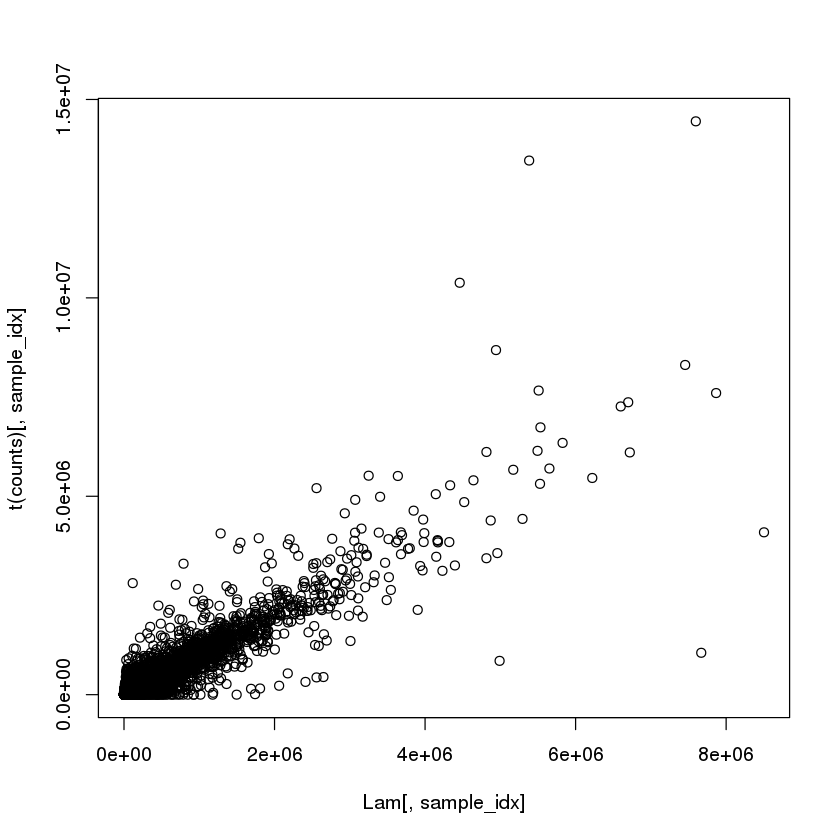

In [10]:
## there are too many points to render at once, so I sample a few hundreds samples to visualize
sample_idx = sample(1:ncol(X), 200,replace = FALSE)
plot(Lam[,sample_idx],t(counts)[,sample_idx])

In [ ]:
plot(X[,sample_idx],t(counts)[,sample_idx])

### Comment:
The Lam, generated X seem to both agree with true counts

### Below I recomputed loglikelihood

In [46]:
## orcale | simulated data
compute_ll(X,F,t(L))

$type
[1] "poisson"

$multinom_ll
[1] -5.535266e+12

$pois_ll
[1] -2.108847

In [26]:
## nnmf model | GTEx
compute_ll(t(counts),F,t(L))

$type
[1] "poisson"

$multinom_ll
[1] -5.527556e+12

$pois_ll
[1] -115.5841

In [1]:
dim(L)

ERROR: Error in eval(expr, envir, enclos): object 'L' not found


## Look more closely at poisson loglikelihood

In [11]:
pois_ll_matrix <- function(X,Lam){
    return(dpois(X,Lam, log = TRUE))
}

ll_oracle_X = pois_ll_matrix(X,Lam)
ll_oracle_counts = pois_ll_matrix(t(counts),Lam)

print("median of loglikelihood: oracle given X VS oracle given GTEx")
print(median(ll_oracle_X))
print(median(ll_oracle_counts))


[1] "median of loglikelihood: oracle given X VS oracle given GTEx"
[1] -1.597184
[1] -1.722693


### test dpois

In [ ]:
pp_l <- function(x,lambda){
    return(log(exp(-lambda)*lambda^x/factorial(x)))
}
testX = matrix(c(1,2,3,4), nrow = 2)
Lambda = matrix(c(10,20,30,40), nrow = 2)
print(sum(dpois(testX,Lambda, log = TRUE)))
print(sum(pp_l(testX,Lambda)))